# Analisi esplorativa e clustering

Questo notebook presenta l'analisi esplorativa del training set.

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import seaborn as sns

import tqdm

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.metrics.pairwise as pw

# %matplotlib inline

export_images = True
style = 'white'
img_folder = './img/'

# tune this for bigger figures
pl.rcParams['figure.figsize'] = (14, 14)
sns.set_context('notebook')

Carichiamo il dataset:

In [2]:
dataset_raw = pd.read_excel("./Dataset/finali/integrato_2014.xlsx", sheet_name='ML_finale')
dataset_raw.head()

,Country code,Country name,Population,CO2 production (kg),Charcoal consumption (kg),Fuel oil consumption (kg),Renewable energy consumption (percentage),PM2.5 (micrograms),GDP
0,AFG,Afghanistan,32758020,9.809225e+09,1.259260e+08,4.407000e+08,16.748996,49.026761,2.005019e+10
1,AGO,Angola,26920466,3.476316e+10,1.164000e+09,3.081000e+03,50.797466,35.129513,1.267770e+11
2,AND,Andorra,79223,4.620420e+08,2.900000e+04,1.299600e+02,19.886327,10.389338,3.350736e+09
3,ARE,United Arab Emirates,9070867,2.113695e+11,6.400000e+07,4.957000e+03,0.167807,67.175459,4.031980e+11
4,ARG,Argentina,42981515,2.040245e+11,4.940000e+08,9.759000e+03,10.773125,13.678616,5.263200e+11


Per comodità rinominiamo le colonne:

In [3]:
dataset_raw = dataset_raw.rename(columns={'CO2 production (kg)': 'CO2',
                           'Charcoal consumption (kg)': 'Charcoal',
                           'Fuel oil consumption (kg)': 'Fuel oil',
                           'Renewable energy consumption (percentage)': 'Clean energy',
                           'PM2.5 (micrograms)': 'PM2.5'})
dataset_raw.head()

,Country code,Country name,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,32758020,9.809225e+09,1.259260e+08,4.407000e+08,16.748996,49.026761,2.005019e+10
1,AGO,Angola,26920466,3.476316e+10,1.164000e+09,3.081000e+03,50.797466,35.129513,1.267770e+11
2,AND,Andorra,79223,4.620420e+08,2.900000e+04,1.299600e+02,19.886327,10.389338,3.350736e+09
3,ARE,United Arab Emirates,9070867,2.113695e+11,6.400000e+07,4.957000e+03,0.167807,67.175459,4.031980e+11
4,ARG,Argentina,42981515,2.040245e+11,4.940000e+08,9.759000e+03,10.773125,13.678616,5.263200e+11


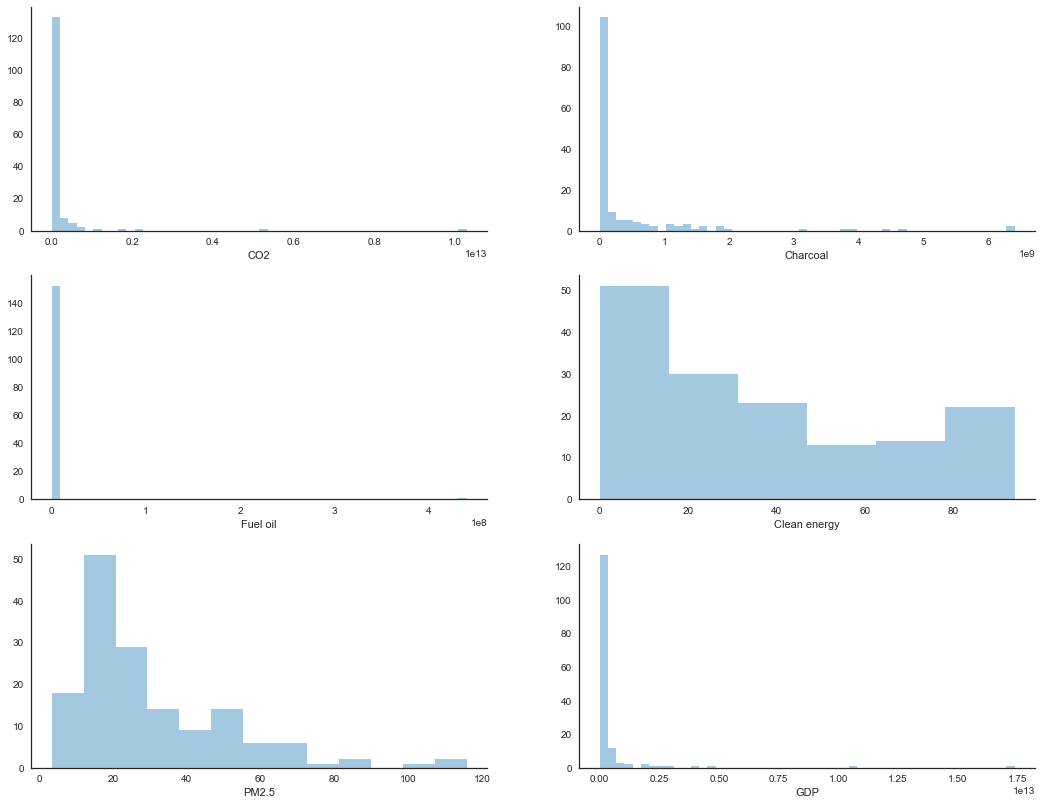

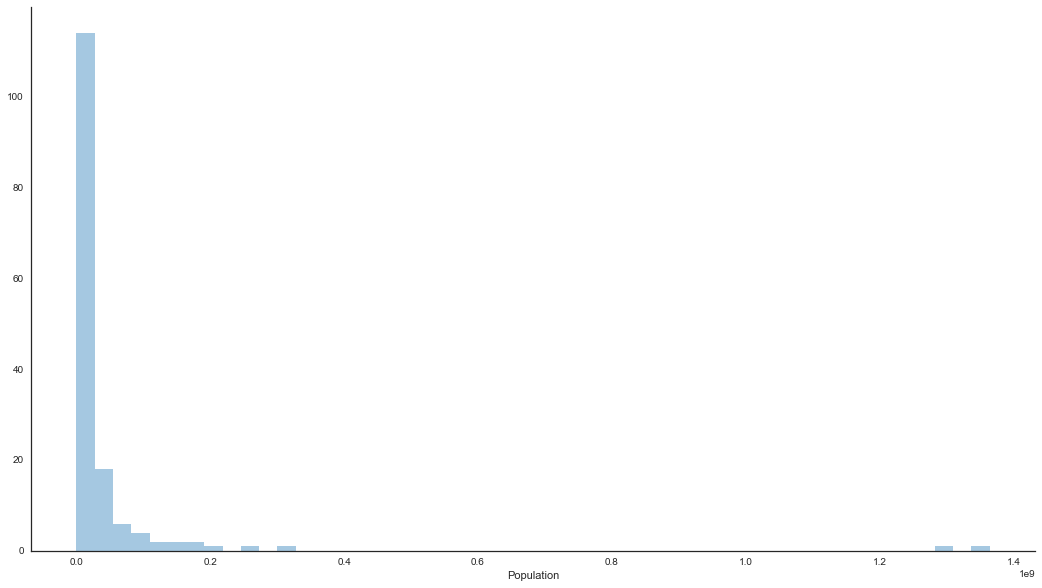

In [4]:
# Plot the original dataset
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(3, 2, figsize=(18, 14))
    plot_kde = False
    sns.distplot(dataset_raw['CO2'], ax=ax[0, 0], kde=plot_kde)
    sns.distplot(dataset_raw['Charcoal'], ax=ax[0, 1], kde=plot_kde)
    sns.distplot(dataset_raw['Fuel oil'], ax=ax[1, 0], kde=plot_kde)
    sns.distplot(dataset_raw['Clean energy'], ax=ax[1, 1], kde=plot_kde)
    sns.distplot(dataset_raw['PM2.5'], ax=ax[2, 0], kde=plot_kde)
    sns.distplot(dataset_raw['GDP'], ax=ax[2, 1], kde=plot_kde)
    sns.despine()
    
    fig2, ax2 = pl.subplots(figsize=(18, 10))
    sns.distplot(dataset_raw['Population'], ax=ax2, kde=plot_kde)
    sns.despine()
    
    pl.show()

    if export_images:
        fig.savefig(img_folder + 'dataset-originale.png', bbox_inches='tight')
        fig2.savefig(img_folder + 'dataset-originale-popolazione.png', bbox_inches='tight')
        sns.set_context('notebook')

Vediamo le distribuzioni appaiate dei dati originali:

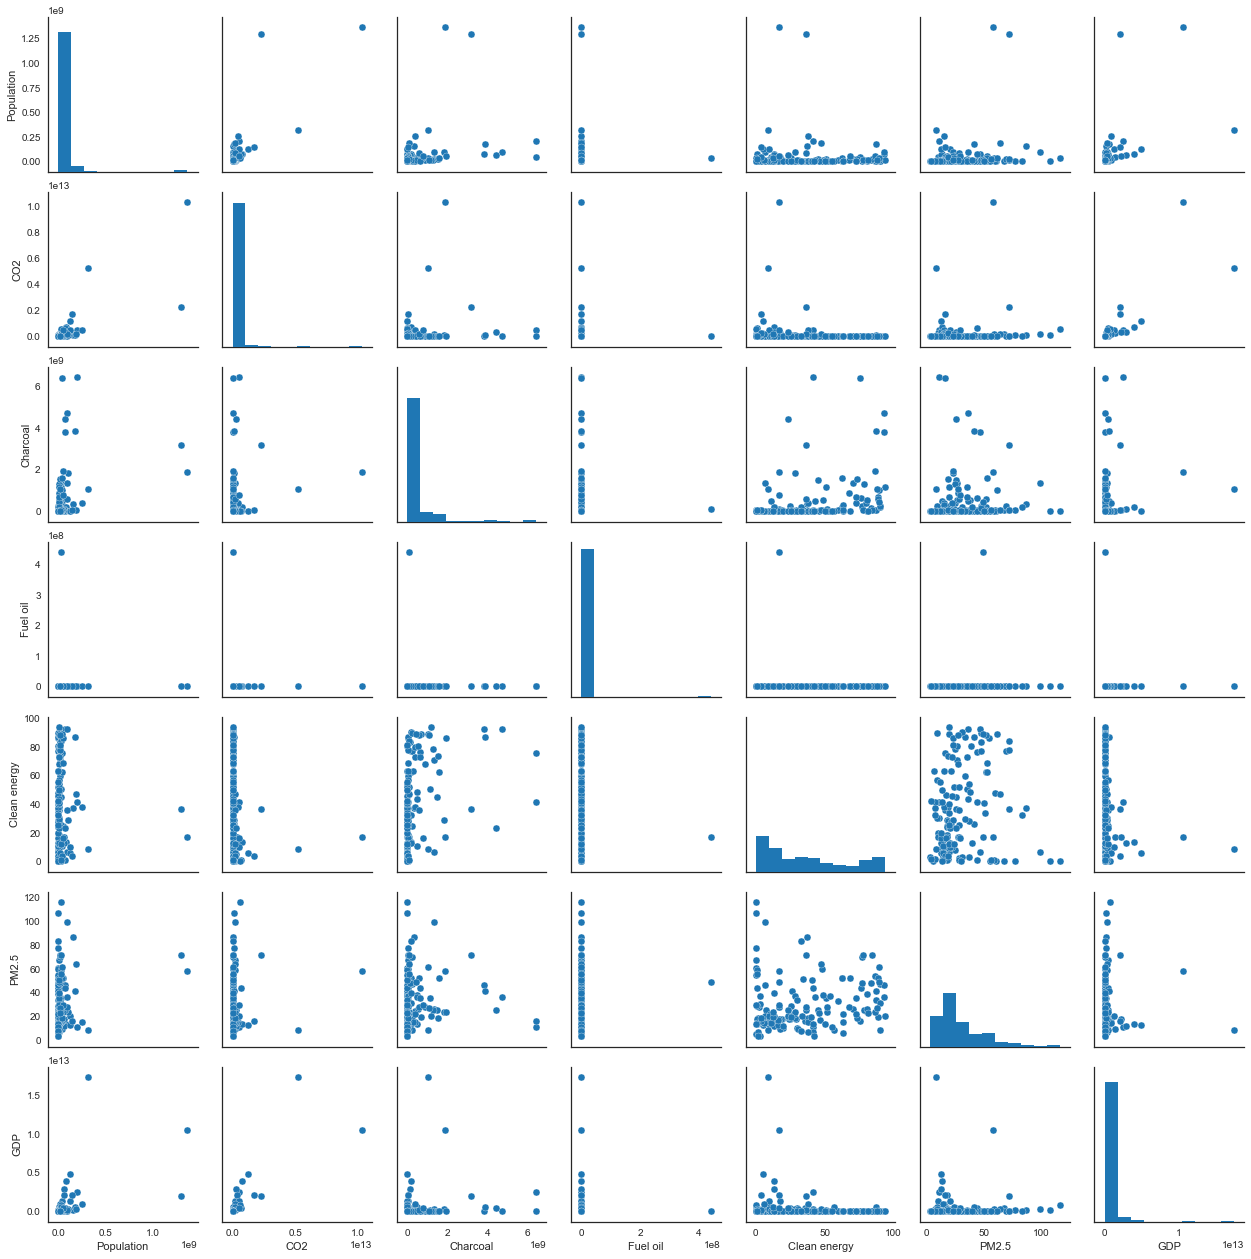

In [5]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(dataset_raw)
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-originale.png', bbox_inches='tight')
        sns.set_context('notebook')

Normalizziamo gli attributi rispetto alla popolazione:

In [6]:
def normalize_with_col(dataset, ref_column=None, cols_to_normalize=None):
    """Divide all columns in a dataset for the normalization column."""
    if ref_column is None:
        raise ValueError("Must choose a reference column to normalize.")
    if cols_to_normalize is None:
        raise ValueError("Must select target columns.")

    norm_col = dataset[ref_column]
    result = dataset.copy()
    
    for col in cols_to_normalize:
        result[col] = result[col] / norm_col
    
    return result

In [7]:
dataset = normalize_with_col(dataset_raw,
                             ref_column='Population',
                             cols_to_normalize=['CO2', 'Charcoal', 'Fuel oil', 'GDP'])
# Peek at the data
dataset.head()

,Country code,Country name,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,32758020,299.444991,3.844127,13.453194,16.748996,49.026761,612.069651
1,AGO,Angola,26920466,1291.328315,43.238479,0.000114,50.797466,35.129513,4709.316696
2,AND,Andorra,79223,5832.169951,0.366055,0.001640,19.886327,10.389338,42294.994724
3,ARE,United Arab Emirates,9070867,23302.022508,7.055555,0.000546,0.167807,67.175459,44449.775308
4,ARG,Argentina,42981515,4746.797455,11.493313,0.000227,10.773125,13.678616,12245.264040


## Statistiche descrittive per il dataset

Il dataset contiene 153 istanze di paesi, ognuna con gli attributi

- popolazione
- produzione di CO_2 annuale (in kg)
- consumo di carbone annuale (in kg)
- consumo di carburanti fossili annuale (in kg)
- percentuale di energia rinnovabile utilizzata, rispetto all'utilizzo totale di quel paese
- GDP (prodotto interno lordo)

Vediamo come sono distribuite le variabili.

In [8]:
dataset.describe()

,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
count,1.530000e+02,153.000000,153.000000,1.530000e+02,153.000000,153.000000,153.000000
mean,4.388212e+07,4190.103188,17.168798,8.814228e-02,35.687487,30.243552,11756.843728
std,1.560372e+08,6372.361344,25.588456,1.087609e+00,29.876964,21.074852,16910.303310
min,7.277800e+04,44.485376,0.008927,5.180149e-07,0.000000,3.397615,312.748979
25%,2.374419e+06,564.368357,1.077500,4.436075e-05,9.798903,15.780430,1569.928275
50%,9.474511e+06,1902.758910,3.325575,1.342412e-04,28.721289,23.062206,4712.822736
75%,2.832324e+07,5260.352041,29.347377,2.915885e-04,59.903202,39.944650,14201.434596
max,1.364270e+09,45423.239959,138.779013,1.345319e+01,93.859219,115.872278,97200.009655


#### Descrizione del vero dataset utilizzato per clustering

In [9]:
dataset.iloc[:, 3:].describe()

,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
count,153.000000,153.000000,1.530000e+02,153.000000,153.000000,153.000000
mean,4190.103188,17.168798,8.814228e-02,35.687487,30.243552,11756.843728
std,6372.361344,25.588456,1.087609e+00,29.876964,21.074852,16910.303310
min,44.485376,0.008927,5.180149e-07,0.000000,3.397615,312.748979
25%,564.368357,1.077500,4.436075e-05,9.798903,15.780430,1569.928275
50%,1902.758910,3.325575,1.342412e-04,28.721289,23.062206,4712.822736
75%,5260.352041,29.347377,2.915885e-04,59.903202,39.944650,14201.434596
max,45423.239959,138.779013,1.345319e+01,93.859219,115.872278,97200.009655


Ora vediamo la distribuzione delle features:

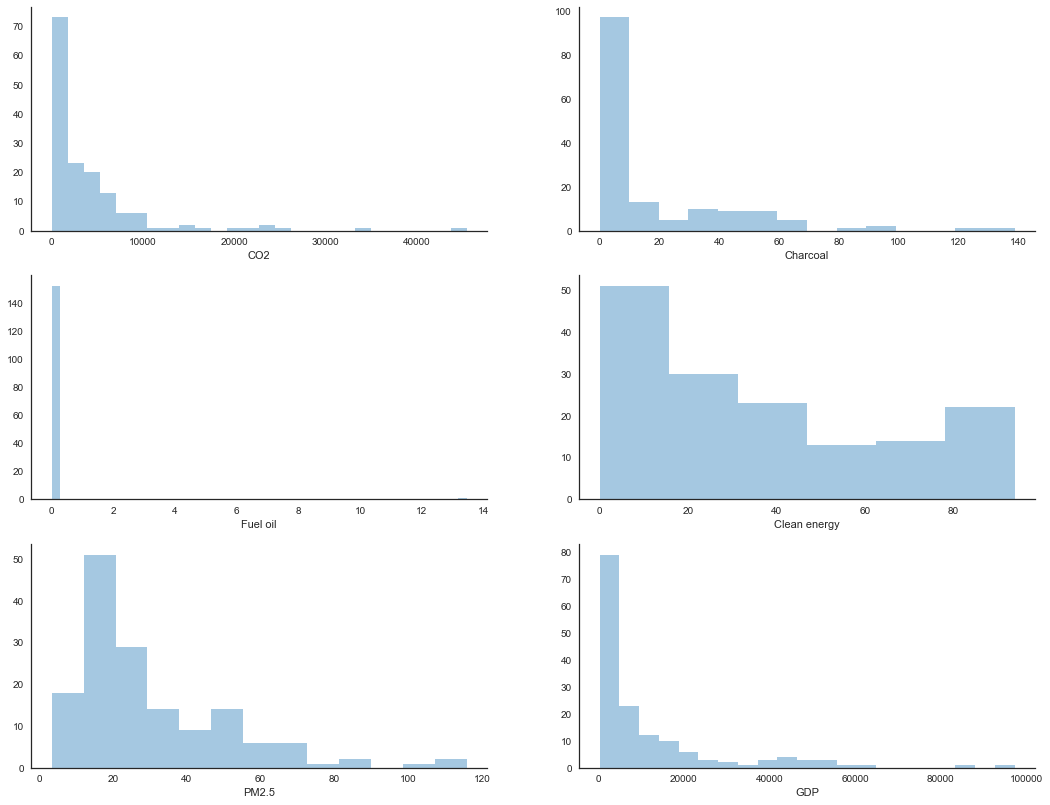

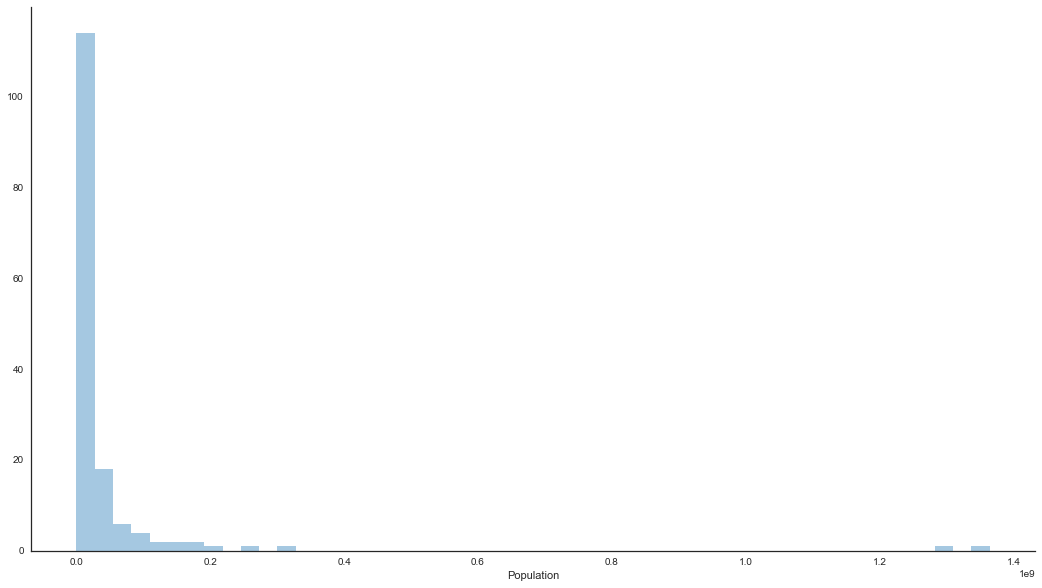

In [10]:
# Plot the population-scaled dataset
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(3, 2, figsize=(18, 14))
    plot_kde = False
    sns.distplot(dataset['CO2'], ax=ax[0, 0], kde=plot_kde)
    sns.distplot(dataset['Charcoal'], ax=ax[0, 1], kde=plot_kde)
    sns.distplot(dataset['Fuel oil'], ax=ax[1, 0], kde=plot_kde)
    sns.distplot(dataset['Clean energy'], ax=ax[1, 1], kde=plot_kde)
    sns.distplot(dataset['PM2.5'], ax=ax[2, 0], kde=plot_kde)  # TODO: sistemare labels
    sns.distplot(dataset['GDP'], ax=ax[2, 1], kde=plot_kde)
    sns.despine()
    
    fig2, ax2 = pl.subplots(figsize=(18, 10))
    sns.distplot(dataset['Population'], ax=ax2, kde=plot_kde)
    sns.despine()
    
    pl.show()

    if export_images:
        fig.savefig(img_folder + 'dataset-scalato-popolazione.png', bbox_inches='tight')
        sns.set_context('notebook')

In [11]:
def standardize(dataset, cols_to_standardize=None):
    """Standardize dataset.
    
    Returns a new copy of the dataset with the
    selcted columns standardized.
    """
    if cols_to_standardize is None:
        raise ValueError("No column passed for standardization")

    result = dataset.copy()
    for col in cols_to_standardize:
        vals = preprocessing.scale(dataset[col].values)
        result.loc[:, col] = vals

    return result

In [12]:
dataset_std = standardize(dataset,
                          cols_to_standardize=[
                              'Population',
                              'CO2',
                              'Charcoal',
                              'Fuel oil',
                              'Clean energy',
                              'PM2.5',
                              'GDP'])
dataset_std.head()

/Users/pietro/Documents/Universita/Progetto_DT_ML/.venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,Country code,Country name,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,-0.071525,-0.612557,-0.522440,12.328828,-0.635964,0.894189,-0.661217
1,AGO,Angola,-0.109060,-0.456392,1.022152,-0.081203,0.507401,0.232600,-0.418128
2,AND,Andorra,-0.281643,0.258532,-0.658810,-0.079795,-0.530611,-0.945175,1.811821
3,ARE,United Arab Emirates,-0.223829,3.009039,-0.396525,-0.080804,-1.192769,1.758171,1.939663
4,ARG,Argentina,-0.005791,0.087648,-0.222527,-0.081099,-0.836637,-0.788586,0.028978


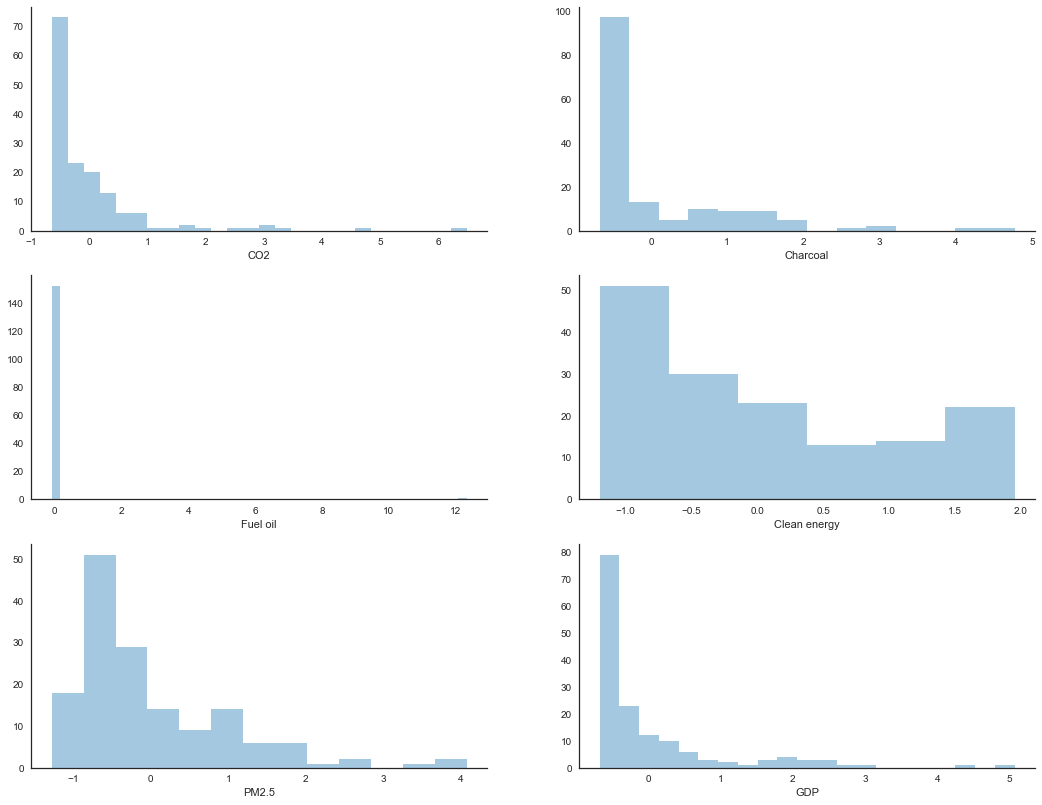

In [13]:
# Plot the standardized population-scaled dataset
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(3, 2, figsize=(18, 14))
    plot_kde = False
    sns.distplot(dataset_std['CO2'], ax=ax[0, 0], kde=plot_kde)
    sns.distplot(dataset_std['Charcoal'], ax=ax[0, 1], kde=plot_kde)
    sns.distplot(dataset_std['Fuel oil'], ax=ax[1, 0], kde=plot_kde)
    sns.distplot(dataset_std['Clean energy'], ax=ax[1, 1], kde=plot_kde)
    sns.distplot(dataset_std['PM2.5'], ax=ax[2, 0], kde=plot_kde)  # TODO: sistemare labels
    sns.distplot(dataset_std['GDP'], ax=ax[2, 1], kde=plot_kde)
    sns.despine()
    pl.show()

    if export_images:
        fig.savefig(img_folder + 'dataset-std.png', bbox_inches='tight')
        sns.set_context('notebook')

#### Pairplot del dataset standardizzato

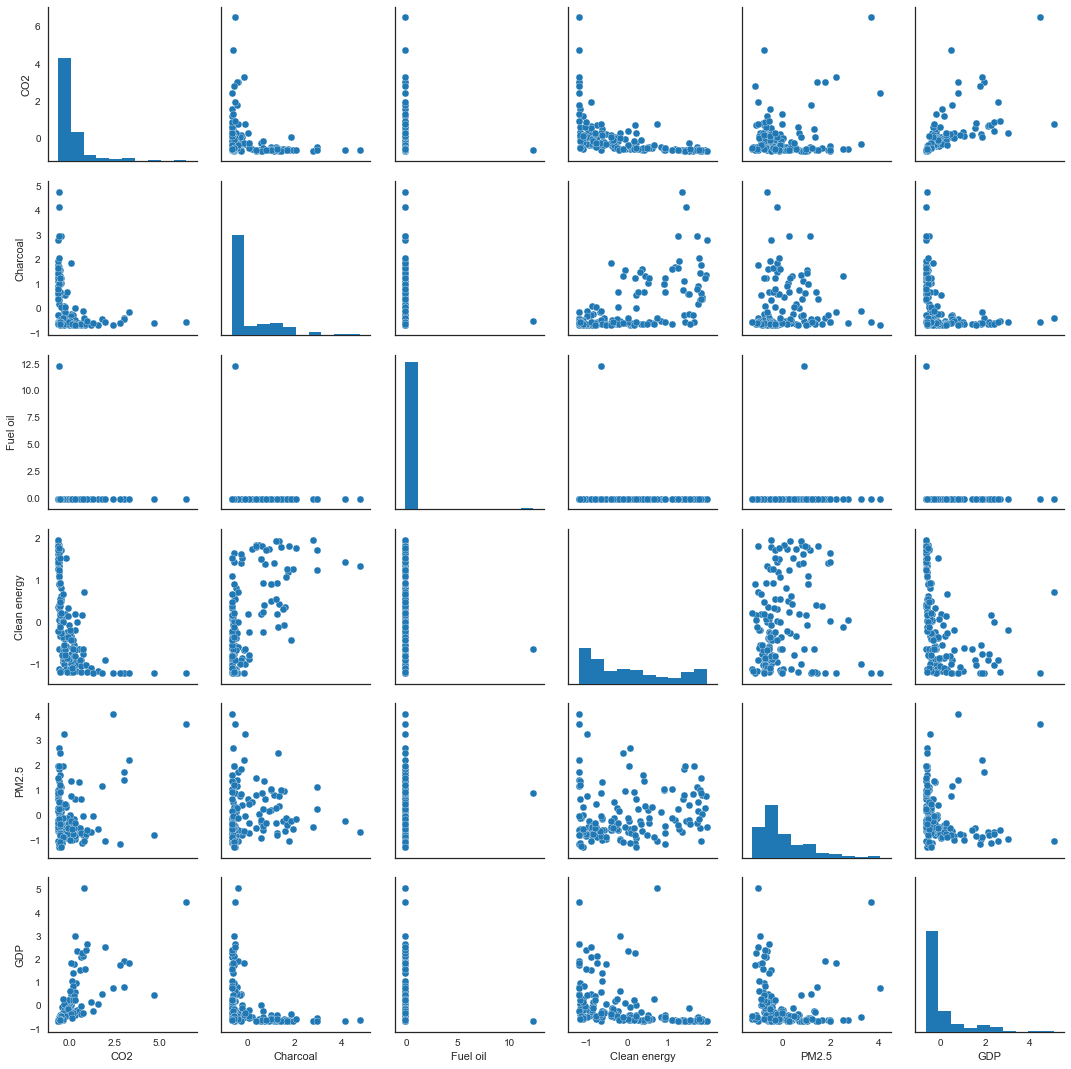

In [14]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(dataset_std.loc[:,
                                           ['CO2',
                                           'Charcoal',
                                           'Fuel oil',
                                           'Clean energy',
                                           'PM2.5',
                                           'GDP']])
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-std.png', bbox_inches='tight')
        sns.set_context('notebook')

#### Pairplot del dataset non standardizzato

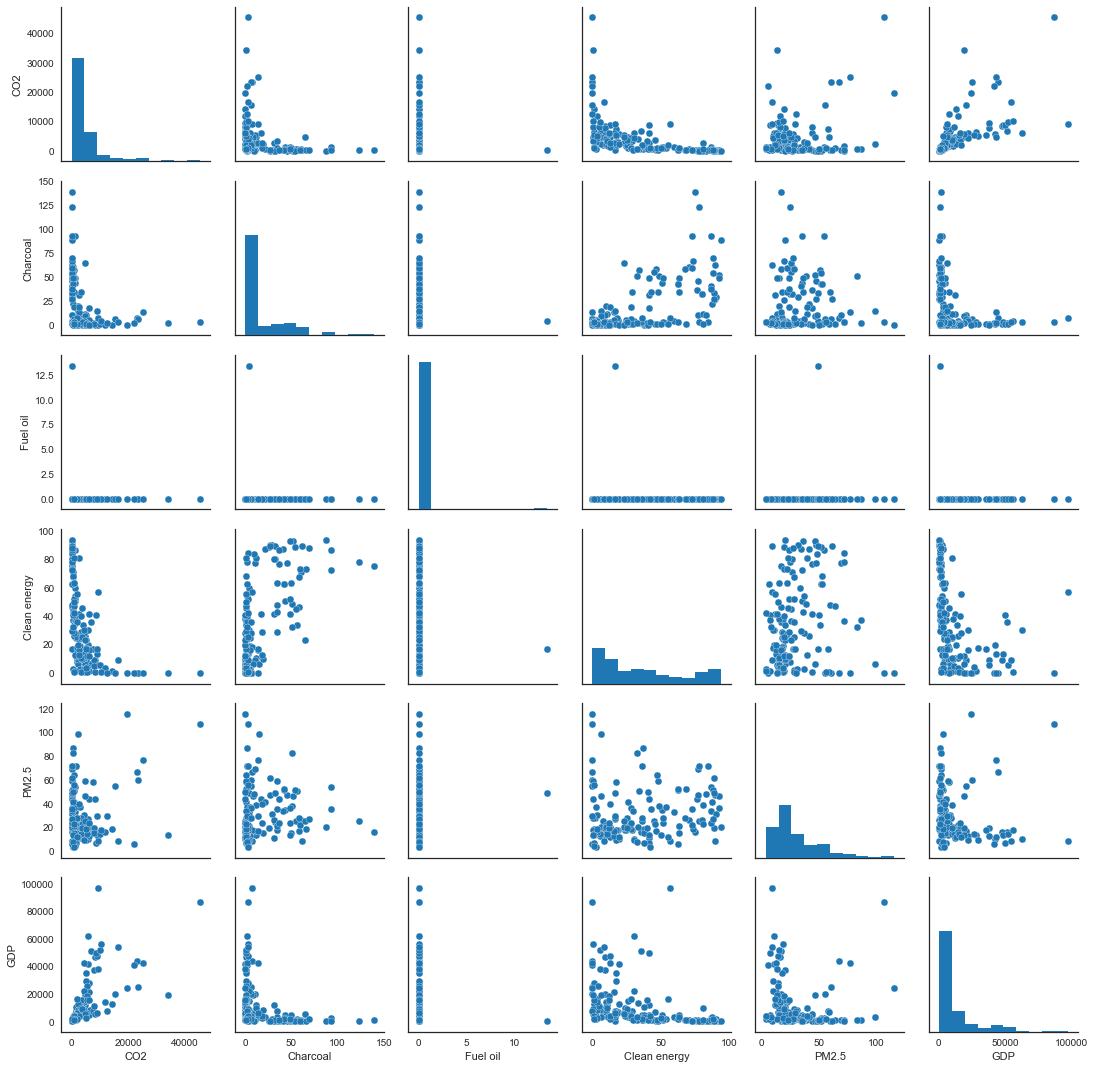

In [15]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(dataset.loc[:,
                                           ['CO2',
                                           'Charcoal',
                                           'Fuel oil',
                                           'Clean energy',
                                           'PM2.5',
                                           'GDP']])
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-non-std.png', bbox_inches='tight')
        sns.set_context('notebook')

## Correlazione tra features

Esploriamo la correlazione tra le features con una heatmap:

In [16]:
def create_heatmap(dataset, figsize=(14, 14)):
    """Create a heatmap from the dataset."""
    # Compute the correlation matrix
    corr = dataset.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = pl.subplots(figsize=figsize)
    
    # Generate a custom diverging colormap
    cmap = sns.color_palette("RdBu")
    
    # Draw the heatmap with the mask and correct aspect ratio
    hm = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, cmap=cmap, annot=True,
                     square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return hm

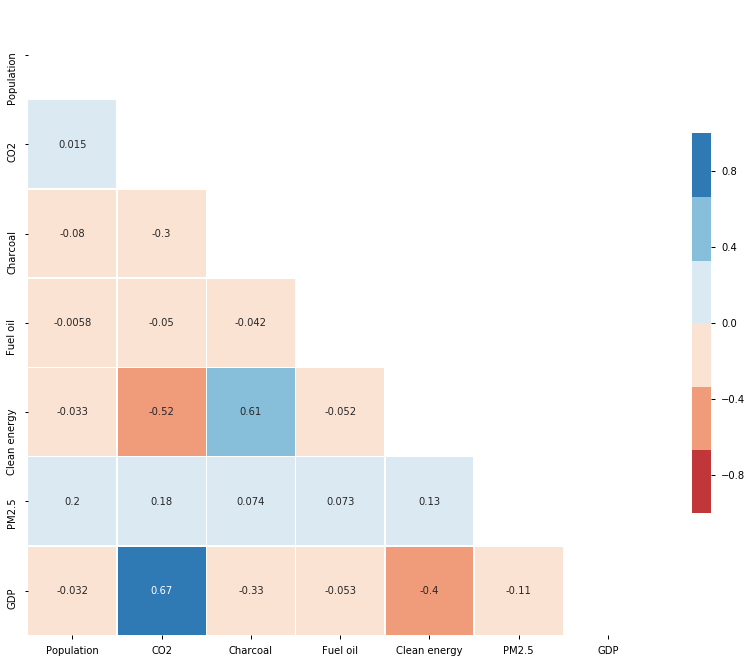

In [17]:
if export_images:
    sns.set_context('poster')
    
heatmap = create_heatmap(dataset)

if export_images:
    fig = heatmap.figure
    fig.savefig(img_folder + 'correlazione.png', bbox_inches='tight')
    sns.set_context('notebook')

# K-Means con Scikit-Learn

Ora che abbiamo esplotato il dataset, utilizziamo Sklearn per indurre un modello K-Means.

### Selezione delle feature

Da quanto emerge dall'analisi esplorativa, la feature "Fuel Oil Consumption" è estremamente sbilanciata verso lo zero, con solo l'Afghanistan a superare quota 10 kg per-capita.

In base a ciò, si è deciso di **eliminare la feature e ritenere soltanto le altre**, scalate rispetto alla popolazione e **standardizzate**.

In [18]:
data_km = dataset_std.copy()
data_km = data_km.drop(columns=['Fuel oil', 'Population'])
data_km.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,-0.612557,-0.522440,-0.635964,0.894189,-0.661217
1,AGO,Angola,-0.456392,1.022152,0.507401,0.232600,-0.418128
2,AND,Andorra,0.258532,-0.658810,-0.530611,-0.945175,1.811821
3,ARE,United Arab Emirates,3.009039,-0.396525,-1.192769,1.758171,1.939663
4,ARG,Argentina,0.087648,-0.222527,-0.836637,-0.788586,0.028978


Come esperimento comparativo, teniamo anche un dataset non standardizzato per il clustering.

In [19]:
data_km_non_std = dataset.copy()
data_km_non_std = data_km_non_std.drop(columns=['Fuel oil', 'Population'])
data_km_non_std.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,299.444991,3.844127,16.748996,49.026761,612.069651
1,AGO,Angola,1291.328315,43.238479,50.797466,35.129513,4709.316696
2,AND,Andorra,5832.169951,0.366055,19.886327,10.389338,42294.994724
3,ARE,United Arab Emirates,23302.022508,7.055555,0.167807,67.175459,44449.775308
4,ARG,Argentina,4746.797455,11.493313,10.773125,13.678616,12245.264040


### Pair-wise plot delle feature scelte


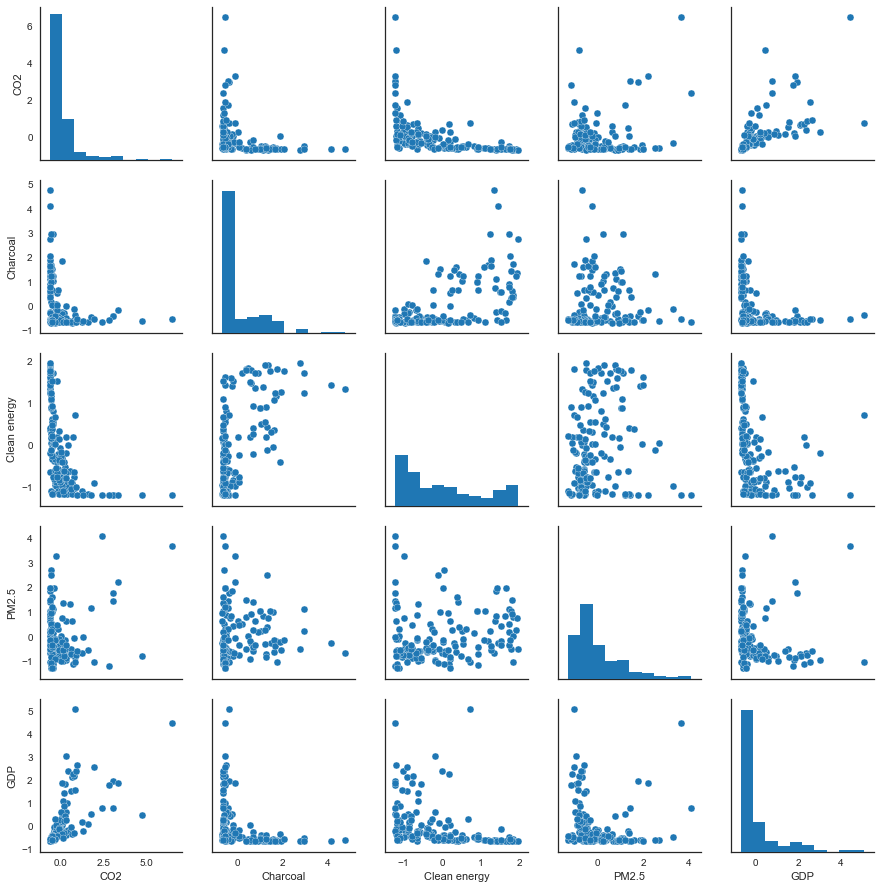

In [20]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(data_km, size=2.5)
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-KMeans.png', bbox_inches='tight')
        sns.set_context('notebook')

## Clustering

Ora che il dataset è standardizzato, procediamo a clusterizzare.

Per trovare la migliore clusterizzazoine, creiamo una funzione.

In [21]:
def clusterize(X, min_clusters, max_clusters):
    n_clusters = list(range(min_clusters, max_clusters + 1))
    
    # (i, j) -> label for data point i when using n_clusters[j] clusters
    labels = np.zeros((X.shape[0], len(n_clusters)), dtype=np.int16)
    
    # (0, j) -> average silhouette score when using n_clusters[j] clusters
    silh_tot = np.zeros((1, len(n_clusters)))
    
    # (i, j) -> silhouette score for data point i when using n_clusters[j] clusters
    silh_ith = np.zeros((X.shape[0], len(n_clusters)))
    
    centroids = dict()
    inertia = dict()
    
    for ind, n in enumerate(tqdm.tqdm_notebook(n_clusters)):
        clusterer = KMeans(n_clusters=n, init='k-means++', n_init=10,
                           max_iter=100000, tol=1e-7,
                           precompute_distances=True, random_state=10,
                           n_jobs=1)
        
        curr_labels = clusterer.fit_predict(X)
        labels[:, ind] = curr_labels

        silhouette_avg = silhouette_score(X, curr_labels)
        silh_tot[0, ind] = silhouette_avg

        curr_silhouette_values = silhouette_samples(X, curr_labels)
        silh_ith[:, ind] = curr_silhouette_values
        
        centroids[n] = clusterer.cluster_centers_
        inertia[n] = clusterer.inertia_

    ret_labels = pd.DataFrame(data=labels, columns=n_clusters)
    ret_silh_avg = pd.DataFrame(data=silh_tot, columns=n_clusters)
    ret_silh_point = pd.DataFrame(data=silh_ith, columns=n_clusters)

    return ret_labels, ret_silh_avg, ret_silh_point, centroids, inertia

Ora lanciamo il K-Means su un numero variabile di clusters, da 2 a 100. Vediamo poi quale è il migliore con l'indice di silhouette

In [22]:
data_values = data_km[['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP']].values
labels, avg_silhouette, point_silhouette, centroids, inertia = clusterize(data_values, 2, 50)

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

In [23]:
best_index = np.argmax(avg_silhouette.values)
best_silhouette = avg_silhouette.iloc[0, best_index]
best_n_cluster = avg_silhouette.columns[best_index]
best_centroids = centroids[best_n_cluster]
best_inertia = inertia[best_n_cluster]

best_cluster_labels = labels[labels.columns[best_index]].values

print("Standardized clustering")
print("Best silhouette score is {:6.4f} with {} clusters"
     .format(best_silhouette, best_n_cluster))

Standardized clustering
Best silhouette score is 0.3929 with 4 clusters


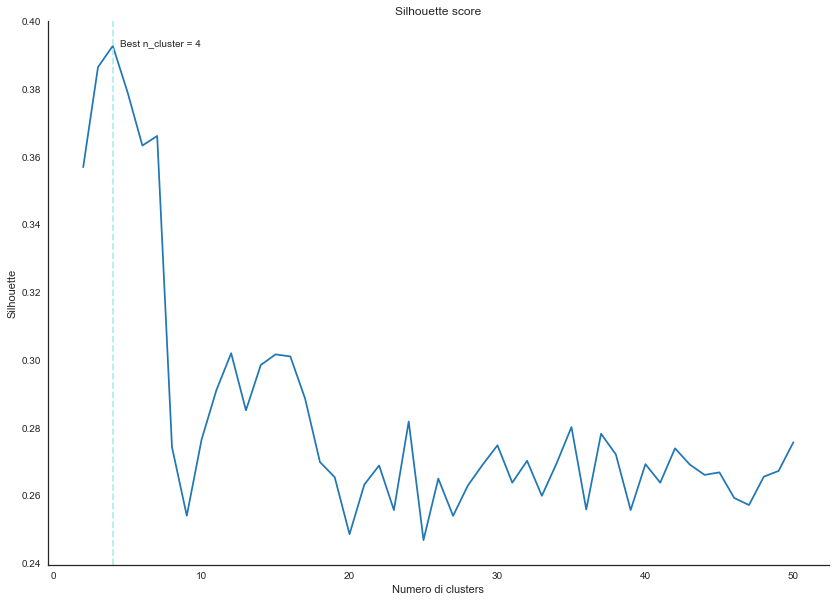

In [26]:
### Plot andamento silhouette media con il numero di clusters
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')

    avg_silh_plot = avg_silhouette.loc[0, :].values
    fig, ax = pl.subplots(ncols=1, figsize=(14, 10))
    pl.plot(np.array(avg_silhouette.columns.tolist()), avg_silh_plot)
    ax.axvline(x=avg_silhouette.columns.tolist()[np.argmax(avg_silh_plot)], color='paleturquoise', linestyle='--')
    ax.text(np.argmax(avg_silh_plot) + 2.5, np.max(avg_silh_plot), "Best n_cluster = 4")
    pl.xlabel("Numero di clusters")
    pl.ylabel("Silhouette")
    ax.set_title("Silhouette score")
    sns.despine()
    
    pl.show()
    
    if export_images:
        fig.savefig(img_folder + 'silhouette_vs_nclusters.png', bbox_inches='tight')
        sns.set_context('notebook')

### Plot dei valori di silhouette

Definiamo una funzione per plottare la silhouette:

In [27]:
# define a function that outputs the silhouette values for each cluster
def silhouette_for_clusters(labels, silhouettes):
    if len(labels) != len(silhouettes):
        raise ValueError("Lenght of labels ({}) differs from length of silhouettes ({})"
                        .format(len(labels), len(silhouettes)))

    cluster_names, cluster_size = np.unique(labels, return_counts=True)
    cluster_silh = {n: np.mean(silhouettes[labels == n]) for n in cluster_names}
    
    return cluster_silh, cluster_size

In [28]:
cluster_silh, cluster_size = silhouette_for_clusters(
    best_cluster_labels,
    point_silhouette[best_n_cluster].values
)

In [29]:
print("Ci sono {} clusters per il dataset standardizzato.\n".format(len(cluster_size)))
for ind, size in enumerate(cluster_size):
        print("Cluster {} ha {:3d} elementi e silhouette = {:6.4f}".format(ind, size, cluster_silh[ind]))

Ci sono 4 clusters per il dataset standardizzato.

Cluster 0 ha  81 elementi e silhouette = 0.4255
Cluster 1 ha  48 elementi e silhouette = 0.3409
Cluster 2 ha  17 elementi e silhouette = 0.4501
Cluster 3 ha   7 elementi e silhouette = 0.2342


In [30]:
def plot_silhouette(cluster_labels, avg_silh, point_silh, cluster_silh, n_clusters, fig, ax, context, palette=None):
    """Make a silhouette plot.
    
    Parameters
    ----------
    data: pd.DataFrame
        data corresponding to the plots
        
    cluster_labels: np.array of shape (n_points, 1)
        labels of the cluster for each data point
    
    point_silh: np.array (n_points, 1)
        silhouette for each data point at the defined cluster number n_clusters
    
    avg_silh: float
        average silhouette score for this clusterization
    """
    min_silh_score = point_silh.min()
    max_silh_score = point_silh.max()
    
    ax.set_xlim([min_silh_score, max_silh_score])
    ax.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])
    
    y_lower = 10
    if not palette:
        palette = sns.color_palette('pastel', n_clusters)
    
    for i in range(n_clusters):
        # aggregate silhouette by cluster label and sort it
        silh_values_cluster_i = point_silh[cluster_labels == i]
        silh_values_cluster_i.sort()
        
        ith_cluster_size = silh_values_cluster_i.shape[0]
        y_upper = y_lower + ith_cluster_size
        
        color = palette[i]#cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, silh_values_cluster_i,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label with the cluster number in the middle
        text_x = -0.09 if context != 'talk' else -0.11
        text = "Cluster {}\nsilhouette = {:4.2f}".format(str(i), cluster_silh[i])
        ax.text(text_x, y_lower + 0.5 * ith_cluster_size, text)
        y_lower = y_upper + 10
    
    ax.set_title("Silhouette plot con {} clusters".format(n_clusters))
#    ax.set_yticks([])
    ax.axvline(x=avg_silh, color='paleturquoise', linestyle='--')
    
    return fig, ax

Vediamo la silhouette dei cluster sul dataset standardizzato:

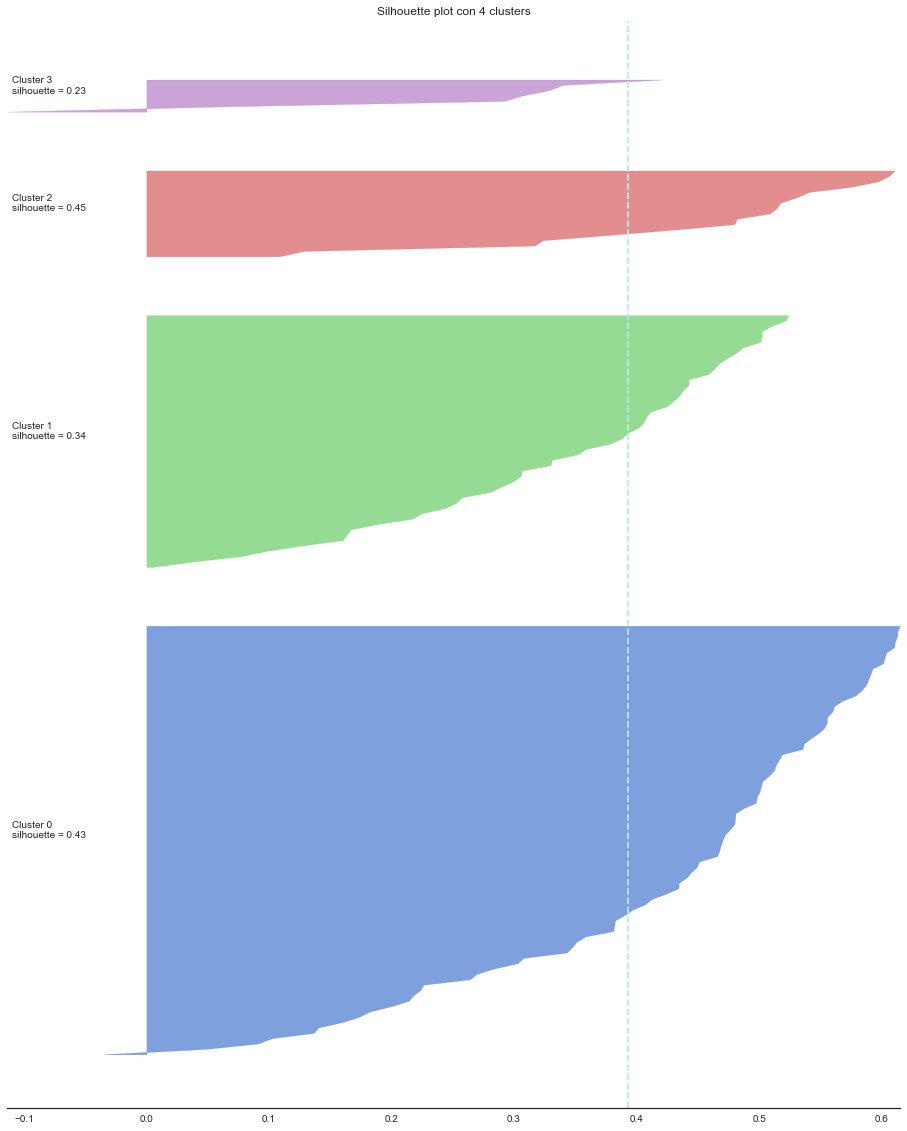

In [31]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(ncols=1, figsize=(16, 20))
    plot_silhouette(labels[best_n_cluster].values,
                    avg_silhouette[best_n_cluster].values,
                    point_silhouette[best_n_cluster].values,
                    cluster_silh,
                    best_n_cluster,
                    fig, ax, 'talk',
                   palette=sns.color_palette('muted', best_n_cluster))
    sns.despine()
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    pl.show()
    
    if export_images:
        fig.savefig(img_folder + 'Silhouette.png', bbox_inches='tight')
        sns.set_context('notebook')

Aggiungo la colonna con i labels al dataset:

In [32]:
data_final = data_km.copy()
data_final['cluster'] = best_cluster_labels
data_final.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP,cluster
0,AFG,Afghanistan,-0.612557,-0.522440,-0.635964,0.894189,-0.661217,0
1,AGO,Angola,-0.456392,1.022152,0.507401,0.232600,-0.418128,1
2,AND,Andorra,0.258532,-0.658810,-0.530611,-0.945175,1.811821,2
3,ARE,United Arab Emirates,3.009039,-0.396525,-1.192769,1.758171,1.939663,3
4,ARG,Argentina,0.087648,-0.222527,-0.836637,-0.788586,0.028978,0


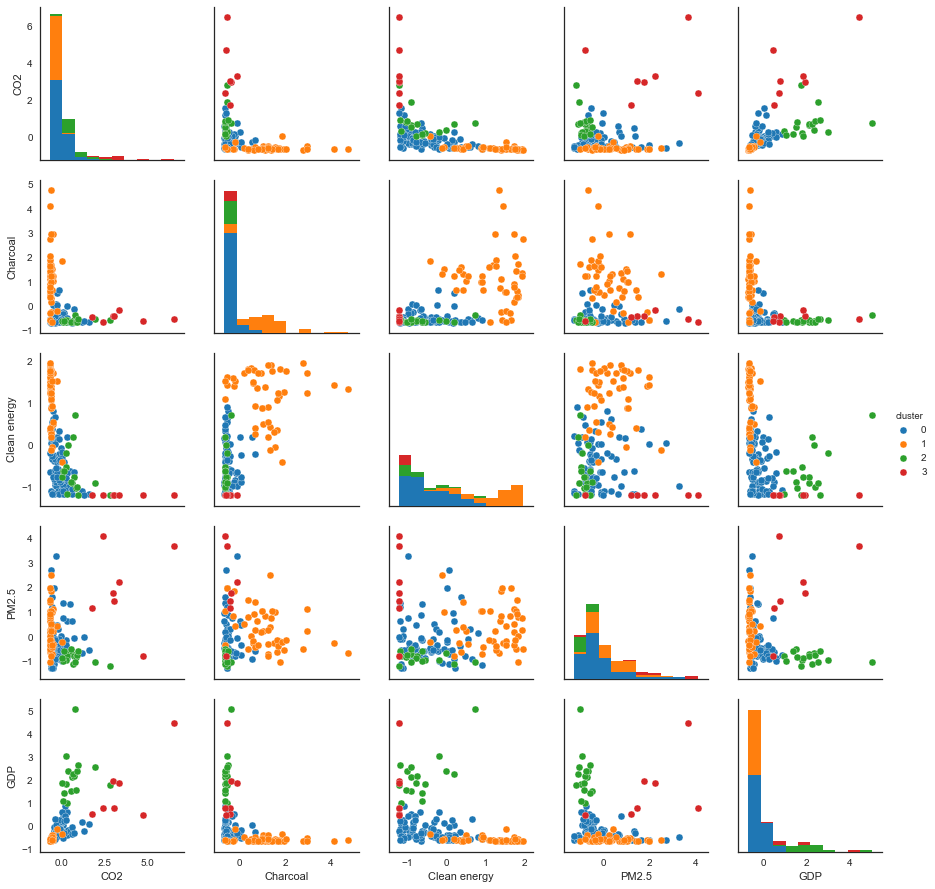

In [33]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(data_final,
                            vars=['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP'],
                            hue='cluster')
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-KMeans-con-clusters.png', bbox_inches='tight')
        sns.set_context('notebook')

### Matrice di dissimilarità

Vediamo ora la matrice di dissimilarità.

Creo una funzione per ordinare i dati a seconda del loro cluster, e all'interno di ogni cluster in base alla distanza dal centroide.

In [35]:
from sklearn.metrics.pairwise import euclidean_distances

In [36]:
def prova(data, centroids):
    """
    data: pd.DataFrame
        contains one data instance per row, and a cloumn 'cluster'
        which gives the cluster label for the instance.
        Must not contain NaNs or None values, else the algorithm fails.
    """
    cluster_labels = np.unique(data['cluster'].values)
    
    new_data = data.sort_values(by='cluster',
                                axis='index',
                                ascending=True,
                                inplace=False)
    tmp = []
    for i in cluster_labels:
        # 1. select the centroid
        centroid = centroids[i, :]
        centroid = centroid.reshape((1, centroid.shape[0]))
        
        # 2. select the data in the i-th cluster
        data_in_cluster_i = new_data[new_data['cluster'] == i]  # all the original data where cluster = i
        data_for_distance = data_in_cluster_i.iloc[:, 2:-1]
        
        # 3. compute distances from centroids
        distances_from_centroid = euclidean_distances(data_for_distance.values, centroid)
        
        # 4. sort the data in the cluster by their distance from the centroid
        data_to_sort = data_in_cluster_i
        data_to_sort['distance from centroid'] = distances_from_centroid
        data_sorted = data_to_sort.sort_values(by='distance from centroid')
        
        tmp.append(data_sorted)
    
    result = tmp[0]
    for i in range(1, len(tmp)):
        result = result.append(tmp[i])

    return result

In [37]:
data_for_plot = prova(data_final, best_centroids)

/Users/pietro/Documents/Universita/Progetto_DT_ML/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
def create_similarity_matrix(data):
    """Create a dissimilarity matrix from the input data,
    considered as (n_samples, n_features)
    """
    distances = pw.pairwise_distances(data, metric='euclidean', n_jobs=1)
    similarity = np.max(distances) - distances
    return similarity
    
def create_distance_matrix(data):
    """Create a distance matrix from the data, considered as (n_samples, n_features)."""
    distances = pw.pairwise_distances(data, metric='euclidean', n_jobs=1)
    return distances

Creiamo la matrice di dissimilarità (o delle distanze):

In [39]:
data_for_plot.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP,cluster,distance from centroid
108,PER,Peru,-0.345842,-0.593412,-0.337544,-0.087222,-0.312417,0,0.313554
128,SUR,Suriname,-0.087552,-0.557954,-0.346046,-0.523015,-0.130077,0,0.372747
114,ROU,Romania,-0.106109,-0.652681,-0.381004,-0.514524,-0.103032,0,0.386991
36,CUB,Cuba,-0.180255,-0.461693,-0.568821,-0.573899,-0.279226,0,0.400477
19,BOL,Bolivia,-0.355457,-0.545594,-0.633649,-0.089769,-0.512184,0,0.417438


In [40]:
to_plot_subset = data_for_plot.iloc[:, 2:-2]
to_plot_subset.head()

,CO2,Charcoal,Clean energy,PM2.5,GDP
108,-0.345842,-0.593412,-0.337544,-0.087222,-0.312417
128,-0.087552,-0.557954,-0.346046,-0.523015,-0.130077
114,-0.106109,-0.652681,-0.381004,-0.514524,-0.103032
36,-0.180255,-0.461693,-0.568821,-0.573899,-0.279226
19,-0.355457,-0.545594,-0.633649,-0.089769,-0.512184


In [41]:
dissimilarity_matrix = create_distance_matrix(to_plot_subset.values)
similarity_matrix = create_similarity_matrix(to_plot_subset.values)

Plottiamo la matrice.

In [42]:
dataframe_for_heatmap = pd.DataFrame(data=dissimilarity_matrix,
                                     index=data_for_plot['Country name'],
                                    columns=data_for_plot['Country name'])
dataframe_for_heatmap.head()

Country name,Peru,Suriname,Romania,Cuba,Bolivia,Serbia,Namibia,Bulgaria,Guyana,Dominican Republic,...,Bahamas,Brunei Darussalam,Norway,Kuwait,United Arab Emirates,Bahrain,Oman,Saudi Arabia,Trinidad and Tobago,Qatar
Country name,,,,,,,,,,,,,,,,,,,,,
Peru,0.000000,0.539636,0.537869,0.579839,0.360514,0.644988,0.336541,0.685458,0.524803,0.598528,...,1.822009,4.034602,5.683469,4.937585,4.527996,3.961682,2.748903,5.182182,5.239340,9.182014
Suriname,0.539636,0.000000,0.106504,0.303848,0.698821,0.355832,0.430956,0.615915,0.372266,0.433602,...,1.469391,3.635307,5.406550,4.895227,4.451911,3.890864,2.745196,5.380325,4.921723,9.087462
Romania,0.537869,0.106504,0.000000,0.334394,0.696631,0.364627,0.449189,0.603381,0.392647,0.466606,...,1.440106,3.630361,5.395396,4.895583,4.445950,3.892184,2.741326,5.370903,4.931175,9.080811
Cuba,0.579839,0.303848,0.334394,0.000000,0.574968,0.452764,0.435899,0.663286,0.288353,0.177991,...,1.507328,3.737942,5.606115,5.009676,4.574623,3.984455,2.817405,5.466099,4.998803,9.236126
Bolivia,0.360514,0.698821,0.696631,0.574968,0.000000,0.714038,0.500318,0.690885,0.560018,0.562700,...,1.867157,4.096728,5.933330,4.990370,4.591417,3.976167,2.745983,5.194689,5.241809,9.272564


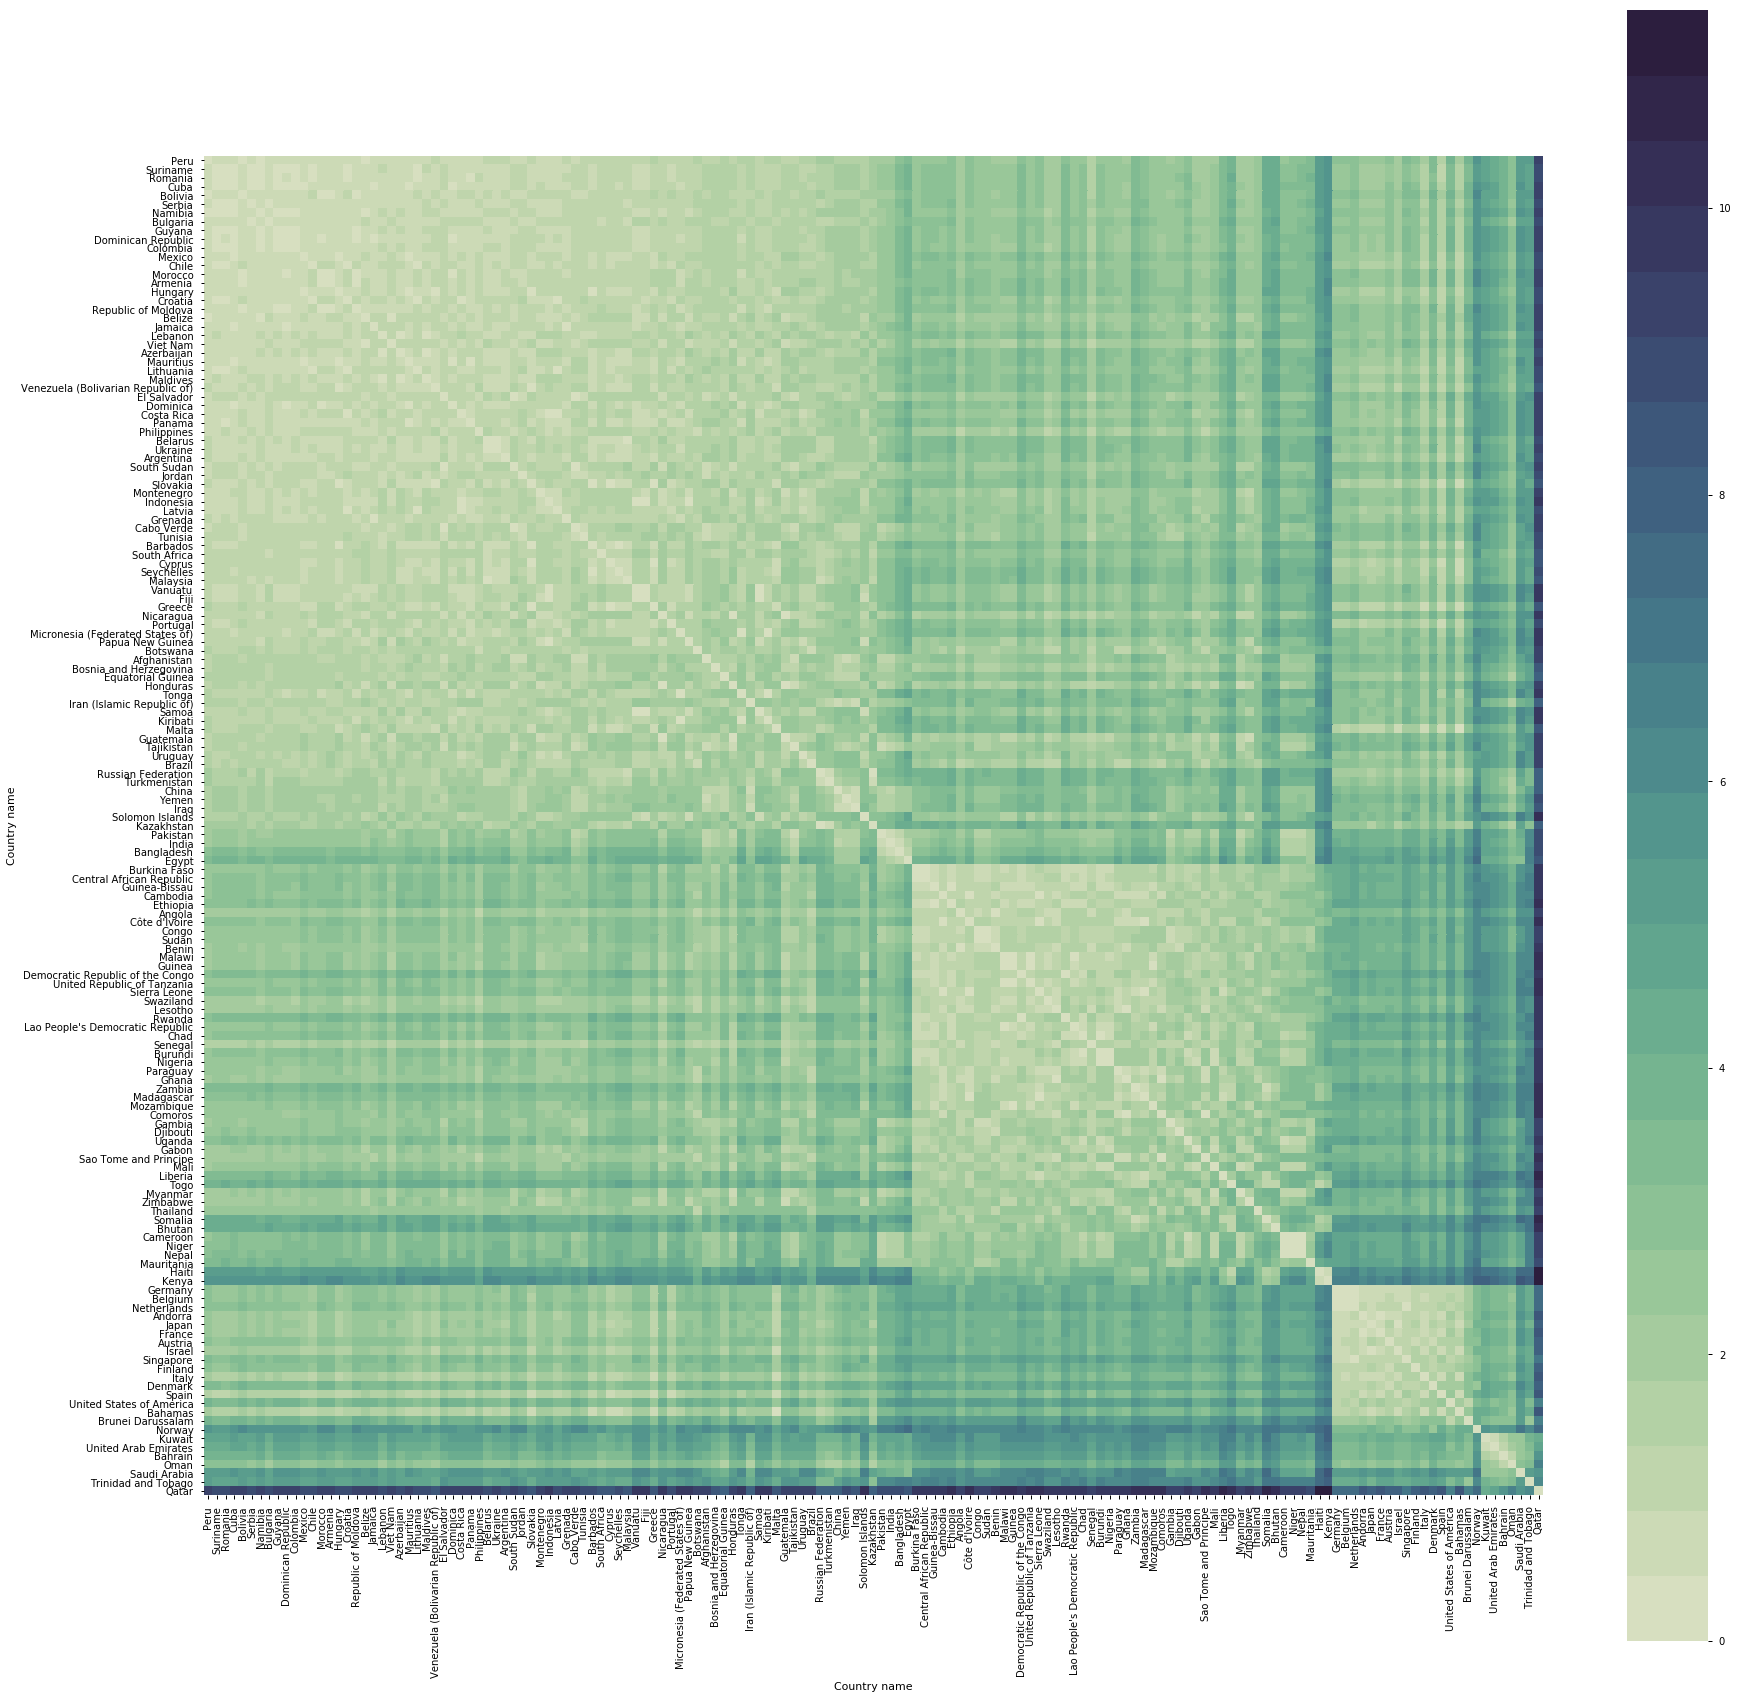

In [78]:
# data_values is the variable containing the data to measure dissimilarity
#colormap = sns.color_palette('BuGn')
colormap = sns.cubehelix_palette(25, start=0.5, rot=-0.75)

if export_images:    
    fig, ax = pl.subplots(figsize=(30, 30))
    sns.heatmap(dataframe_for_heatmap,
                square=True,
                cmap=colormap,
                xticklabels=dataframe_for_heatmap.columns.tolist(),
                yticklabels=dataframe_for_heatmap.columns.tolist(),
                ax=ax)
    pl.show()
    fig.savefig(img_folder + 'dissimilarity-matrix.png', bbox_inches='tight')
else:
    fig, ax = pl.subplots(figsize=(20, 20))
    sns.heatmap(dataframe_for_heatmap,
                square=True,
                cmap=colormap,
                ax=ax)
    pl.show()

## Analisi PCA per la varianza spiegata

Vediamo il contributo di ogni feature alla varianza spiegata dei dati:

In [79]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(dataset_std.loc[:,['CO2',
                                             'Charcoal',
                                             'Clean energy',
                                             'PM2.5',
                                             'GDP']])
pca.explained_variance_ratio_

array([0.48391895, 0.22374997, 0.16608379, 0.08337035, 0.04287694])

In [80]:
pca_ns = PCA(n_components=None)
X_pca_ns = pca_ns.fit_transform(dataset.loc[:,['CO2',
                                             'Charcoal',
                                             'Clean energy',
                                             'PM2.5',
                                             'GDP']])
pca_ns.explained_variance_ratio_

array([9.35582327e-01, 6.44127366e-02, 2.98779851e-06, 1.18374941e-06,
       7.64915493e-07])

In [81]:
def plot_explained_variance(pca_obj, threshold=0.9, despine=False):
    n = len(pca_obj.explained_variance_ratio_)
    x_vals = np.arange(n)
    
    # bar chart
    pl.bar(x_vals,
           pca_obj.explained_variance_ratio_,
           alpha=0.5,
           align="center",
           label="Varianza spiegata attributo")
    
    # step plot
    pl.step(x_vals,
            np.cumsum(pca_obj.explained_variance_ratio_),
            where="mid",
            label="Varianza spiegata cumulata")
    
    # threshold
    p = pl.plot(x_vals,
           threshold * np.ones(x_vals.shape),
           linestyle='--',
           label="Soglia al {}%".format(threshold * 100))
    
    pl.xlabel("Componenti principali")
    pl.ylabel("Rapporto varianza spiegata")
    pl.legend(loc="center right")
    if despine:
        sns.despine()
        
    pl.show()
    return p

Varianza spiegata per dataset standardizzato.

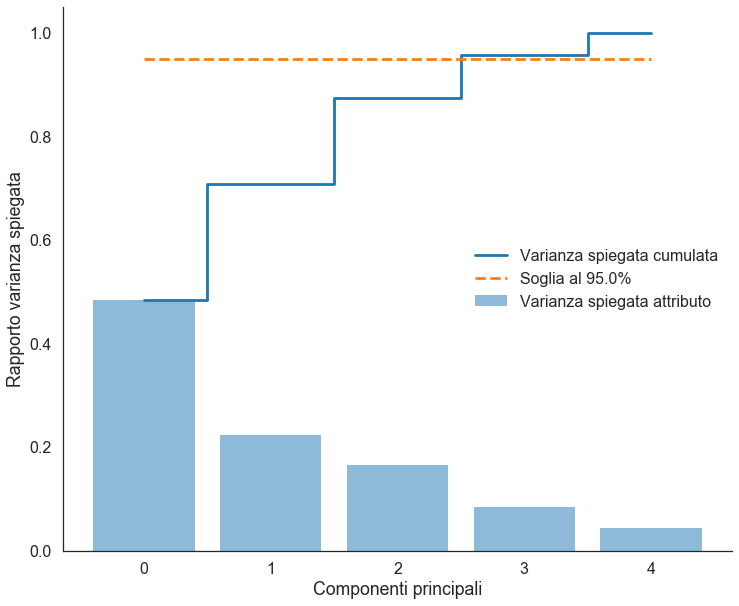

In [82]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')
        
    fig, ax = pl.subplots(ncols=1, figsize=(12, 10))
    plot_explained_variance(pca, threshold=0.95, despine=True)
    
    if export_images:
        fig.savefig(img_folder + 'varianza-spiegata-std.png', bbox_inches='tight')
        sns.set_context('notebook')

Varianza spiegata per dataset non standardizzato.

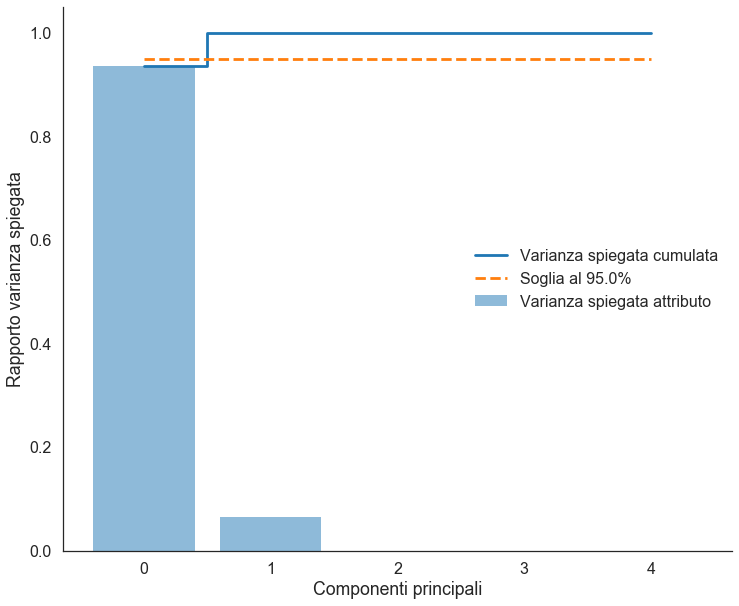

In [83]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')
        
    fig, ax = pl.subplots(ncols=1, figsize=(12, 10))
    plot_explained_variance(pca_ns, threshold=0.95, despine=True)
    
    if export_images:
        fig.savefig(img_folder + 'varianza-spiegata-non-std.png', bbox_inches='tight')
        sns.set_context('notebook')